In [4]:
from numpy import random
class ActionSpace:
    def sample(self):
        return random.randint(0, 1)

In [9]:
import numpy as np
import pandas as pd
from numpy.random import default_rng

rng = default_rng(seed=100)

class NoisyData:
    url = 'https://certificate.tpq.io/findata.csv'
    def __init__(self, symbol, feature, n_features=4,
    min_accuracy=0.485, noise=True,
    noise_std=0.001):
        self.symbol = symbol
        self.feature = feature
        self.n_features = n_features
        self.noise = noise
        self.noise_std = noise_std
        self.action_space = ActionSpace()
        self.min_accuracy = min_accuracy
        self._get_data()
        self._prepare_data()
    def _get_data(self):
            self.raw = pd.read_csv(self.url,
            index_col=0, parse_dates=True)

class NoisyData(NoisyData):
    def _prepare_data(self):
        self.data = pd.DataFrame(self.raw[self.symbol]).dropna()
        if self.noise:
            std = self.data.mean() * self.noise_std
            self.data[self.symbol] = (self.data[self.symbol] +
                rng.normal(0, std, len(self.data)))
        self.data['r'] = np.log(self.data / self.data.shift(1))
        self.data['d'] = np.where(self.data['r'] > 0, 1, 0)
        self.data.dropna(inplace=True)
        ma, mi = self.data.max(), self.data.min()
        self.data_ = (self.data - mi) / (ma - mi)
    def reset(self):
        if self.noise:
            self._prepare_data()
        self.bar = self.n_features
        self.treward = 0
        state = self.data_[self.feature].iloc[
            self.bar - self.n_features:self.bar].values
        return state, {}
    
class NoisyData(NoisyData):
    def step(self, action):
        if action == self.data['d'].iloc[self.bar]:
            correct = True
        else:
            correct = False
        reward = 1 if correct else 0
        self.treward += reward
        self.bar += 1
        self.accuracy = self.treward / (self.bar - self.n_features)
        if self.bar >= len(self.data):
            done = True
        elif reward == 1:
            done = False
        elif (self.accuracy < self.min_accuracy and
        self.bar > self.n_features + 15):
            done = True
        else:
            done = False
        next_state = self.data_[self.feature].iloc[
            self.bar - self.n_features:self.bar].values
        return next_state, reward, done, False, {}

In [10]:
fin = NoisyData(symbol='EUR=', feature='EUR=', noise=True, noise_std=0.005)
fin.reset()
fin.reset()
fin = NoisyData('EUR=', 'r', n_features=4, noise=True, noise_std=0.005)
fin.reset()
fin.reset()

(array([0.37967631, 0.40190291, 0.49196183, 0.47536065]), {})

In [11]:
from pylab import plt, mpl
plt.style.use('seaborn-v0_8')
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

In [12]:
import warnings
warnings.simplefilter('ignore')

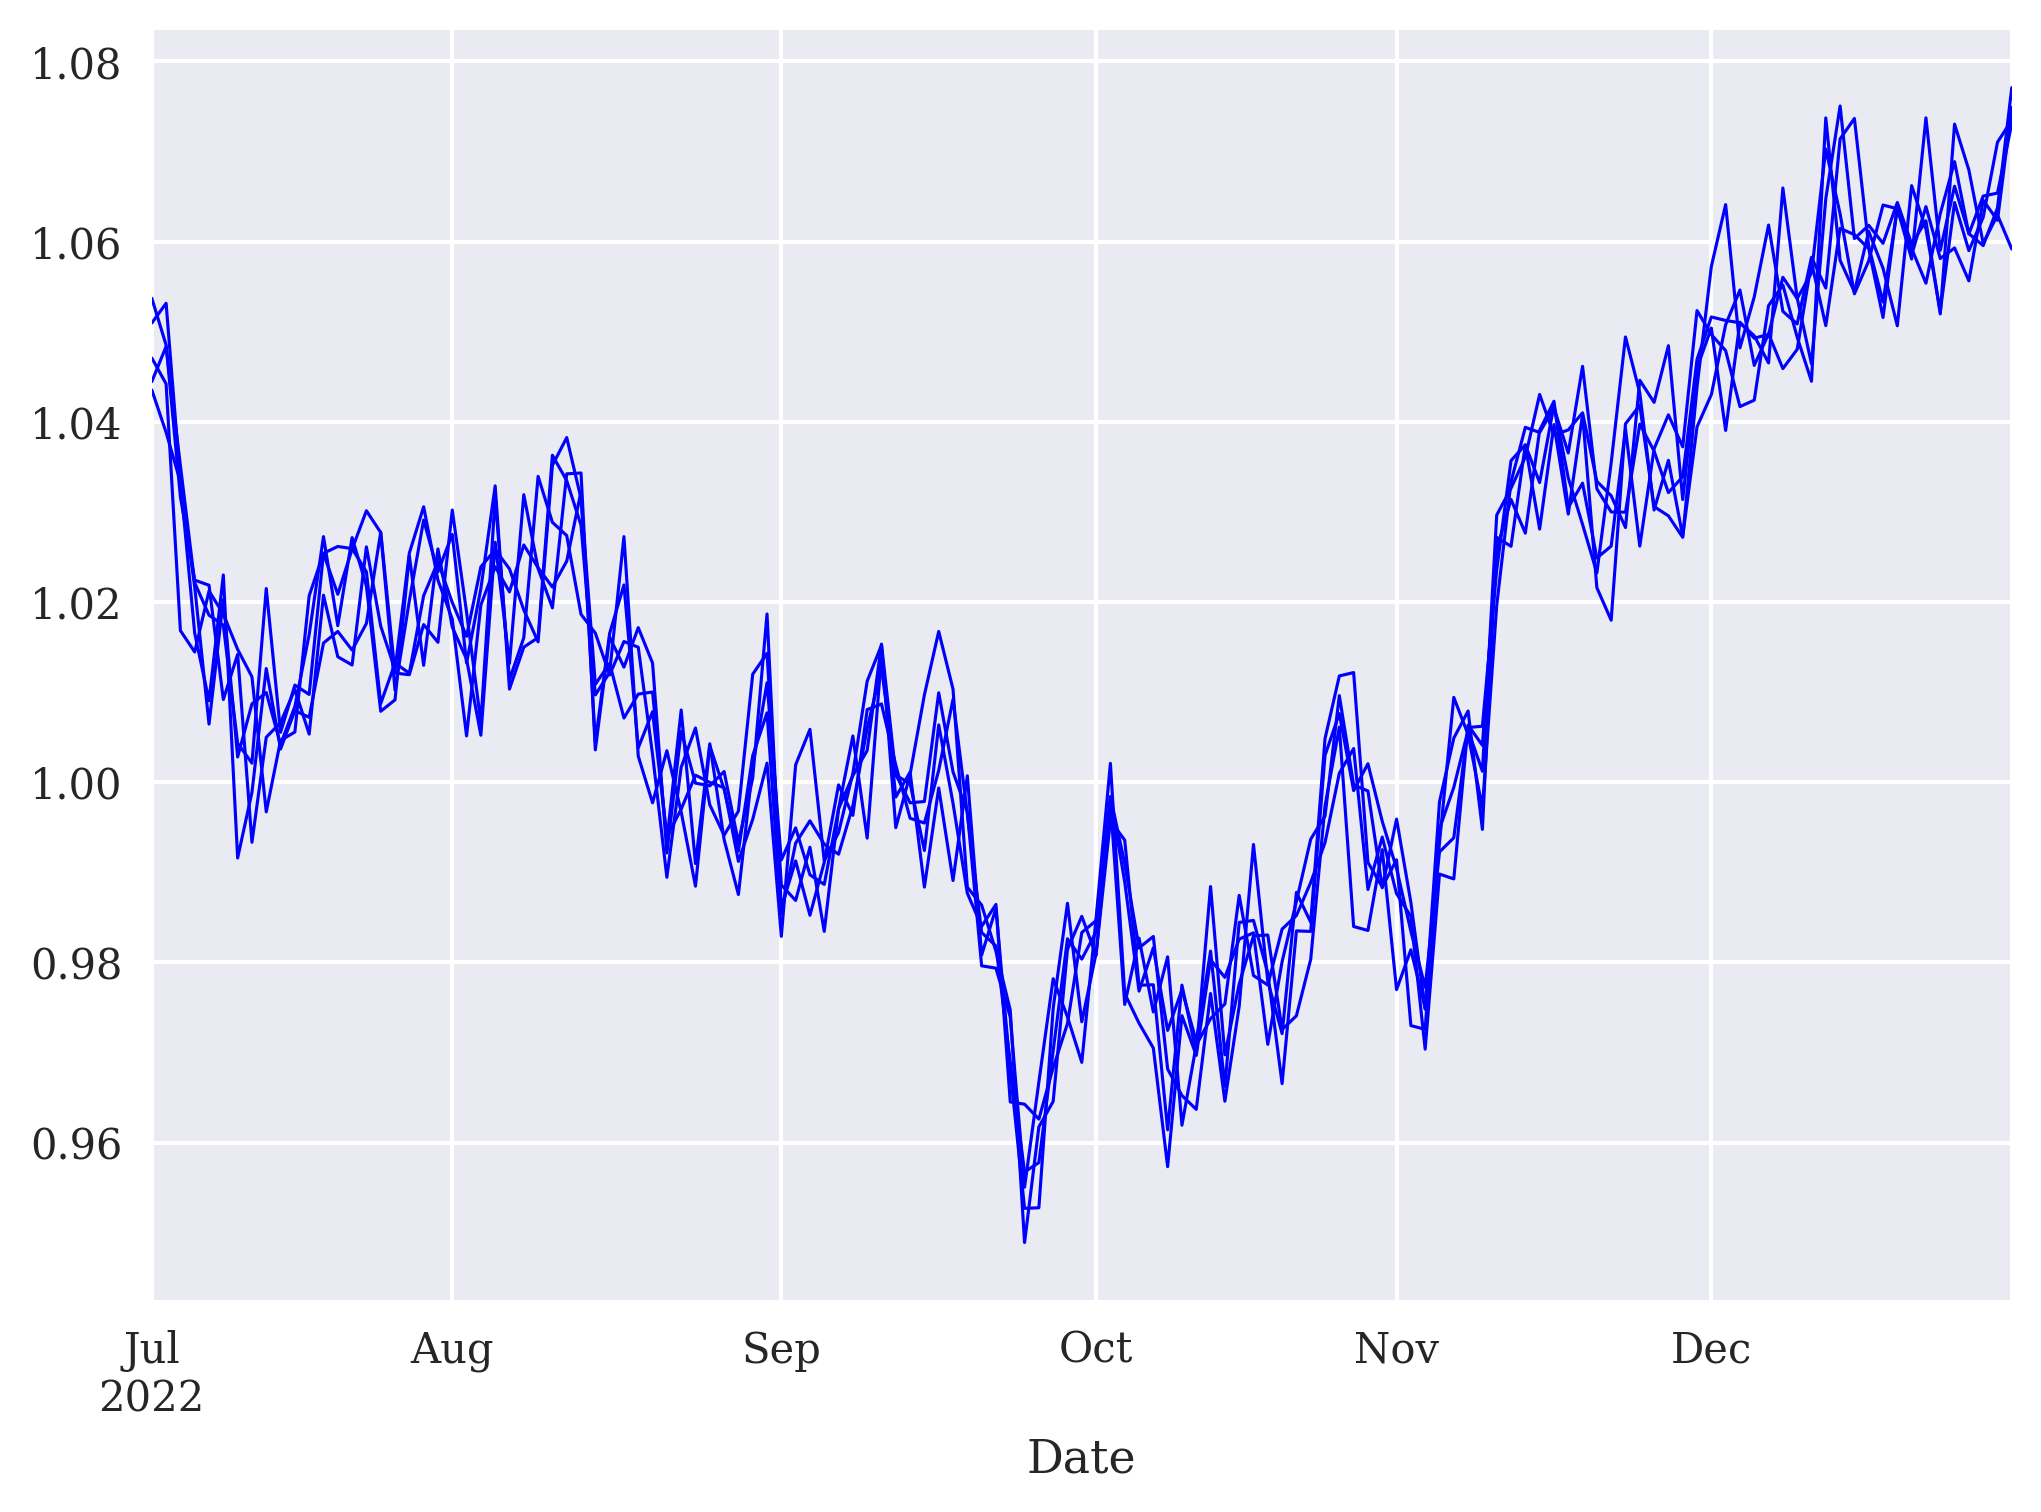

In [13]:
for _ in range(5):
    fin.reset()
    fin.data[fin.symbol].loc['2022-7-1':].plot(lw=0.75, c='b')

In [14]:
%run DQLAgent.py

In [ ]:
import os
import DQLAgent
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
agent = DQLAgent(fin.symbol, fin.feature, fin.n_features, fin)
